<a href="https://colab.research.google.com/github/unnatihasija1/spotifyrecommendations/blob/main/SpotifyRecommendationNew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
pip install spotipy

In [9]:
pip install dbapi

In [10]:
pip install --upgrade hana-ml

In [11]:
pip install pyodbc

In [12]:
import pandas as pd
import os
import json
import hana_ml
from hana_ml.algorithms.pal import clustering
from hana_ml.algorithms.pal import partition
from hana_ml.docstore import create_collection_from_elements as jsoncollection
import hana_ml.dataframe as dataframe
from hana_ml.algorithms.pal.preprocessing import Imputer

In [13]:
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import seaborn as sns
from hana_ml.algorithms.pal.tsne import TSNE
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from hana_ml.artifacts.generators import hana

#import pyodbc as pyodbc

In [14]:
# setup hana connection
conn = dataframe.ConnectionContext(address='14a552ee-5028-4a45-933e-28455029a1c7.hna0.prod-eu10.hanacloud.ondemand.com',
                                   port=443,
                                   user='',
                                   password='',
                                   encrypt='true'
                                   )

In [15]:
conn.sql_tracer.enable_sql_trace(True)
conn.sql_tracer.enable_trace_history(True)

In [16]:
# Create the HANA dataframe in the structure of the specified table
df_remote = conn.table(table = 'AUDIOFEATURES_UH', schema = 'SPOTIFY')
#df_remote = conn.table(table = 'json.Views.tracks::all_tracks_audio_no_nulls', schema = 'DEMOJSON')
df = df_remote.collect()
#df_data = pd.read_csv('/content/spotify.csv')
df_remote.dtypes()
df_remote.describe().collect()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  float64
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           11

In [17]:
# Remove duplicates based on ID column
df_remote = df_remote.drop_duplicates(subset=['ID'])
df = df_remote.collect().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89741 entries, 0 to 89740
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                89741 non-null  object 
 1   artists           89740 non-null  object 
 2   album_name        89740 non-null  object 
 3   track_name        89740 non-null  object 
 4   popularity        89741 non-null  int64  
 5   duration_ms       89741 non-null  float64
 6   explicit          89741 non-null  bool   
 7   danceability      89741 non-null  float64
 8   energy            89741 non-null  float64
 9   key               89741 non-null  int64  
 10  loudness          89741 non-null  float64
 11  mode              89741 non-null  int64  
 12  speechiness       89741 non-null  float64
 13  acousticness      89741 non-null  float64
 14  instrumentalness  89741 non-null  float64
 15  liveness          89741 non-null  float64
 16  valence           89741 non-null  float6

In [18]:
df = df_remote.collect() #pandas df
print(df.head(10))

                       ID                        artists  \
0  76mhYD8ORDyXAKog43BSeQ                    Julia Alexa   
1  2UmRwtqX0LaNkbe598bHIK                          Solee   
2  4B6ko7lt1sUtyFzBDF4yfK                  Manolo Garcia   
3  4q7tMaar2kUMweKu6N5bZz                     Elton John   
4  7gUgDucWxwsrnNGN43MZcu                     Kid Abelha   
5  4XtRA7CmgudlrRtcqTKAAv            Imperative Reaction   
6  7d7whQmni6ZvmfkWE5XEAX                    Jack Harlow   
7  4dVS8rOylV1IMwn0HsQPDH  Southern Culture on the Skids   
8  2UikW3zPTMjb8ORSpnHzaG                        Asspera   
9  1Qnwq7Qu5aDPG9l2ZNRx1A                      Noel Toms   

               album_name                        track_name  popularity  \
0          please hold me                    please hold me          56   
1                  Carant                            Carant          36   
2  Arena En Los Bolsillos                  Pajaros de Barro          63   
3           Honky Chateau  I Think I'm 

In [19]:
#By scaling features to a similar range, normalization allows for fair comparisons between different features.
#It ensures that no single feature's magnitude overshadows others during analysis or modeling.

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numeric_cols1 = ['tempo', 'loudness']
scaler.fit(df[numeric_cols1])
df[numeric_cols1] = scaler.transform(df[numeric_cols1])
print(df[numeric_cols1])

          tempo  loudness
0      0.533558  0.685922
1      0.505432  0.712928
2      0.595755  0.805856
3      0.565381  0.764016
4      0.546386  0.795775
...         ...       ...
89736  0.431504  0.855187
89737  0.520323  0.714130
89738  0.706384  0.892459
89739  0.690388  0.851007
89740  0.405914  0.850267

[89741 rows x 2 columns]


In [20]:
df_remote.collect().fillna(0, inplace=True)
df[numeric_cols1]
# group the dataset by genre and create an Imputer object with the median strategy
grouped = df_remote.collect().groupby('genres')
imputer = Imputer(strategy='median')

df_remote_imputed = imputer.fit_transform(df_remote.drop(['ID', 'artists', 'album_name', 'explicit', 'track_name','popularity', 'duration_ms', 'genres', 'loudness', 'tempo']))
no_feature_cols = ['ID', 'artists', 'album_name', 'explicit', 'track_name','popularity', 'duration_ms', 'genres']
df_id_name = df_remote[no_feature_cols].collect()
concat_df = pd.concat([df_id_name, df_remote_imputed.collect(), df[numeric_cols1]], axis=1)
new_hana_df = dataframe.create_dataframe_from_pandas(
    conn, concat_df, 'TRACKSALLFEATURESUH5')
#print(new_hana_df.collect())
new_hana_df.collect().info()
#df_remote_imputed.collect().head(10)
#df_remote_imputed.collect().info()

INFO:hana_ml.ml_base:Executing SQL: DO
BEGIN
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
param_name[1] := N'IMPUTATION_TYPE';
int_value[1] := 2;
double_value[1] := NULL;
string_value[1] := NULL;
param_name[2] := N'HAS_ID';
int_value[2] := 0;
double_value[2] := NULL;
string_value[2] := NULL;
params = UNNEST(:param_name, :int_value, :double_value, :string_value);
in_0 = SELECT "danceability", "energy", "key", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "time_signature" FROM (SELECT "ID", "artists", "album_name", "track_name", "popularity", "duration_ms", "explicit", "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature", "genres" FROM (SELECT *, ROW_NUMBER() OVER (PARTITION BY "ID") AS "SEQNUM" FROM (SELECT * FROM "SPOTIFY"."AUDIOFEATURES_UH")) WHERE

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89741 entries, 0 to 89740
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                89741 non-null  object 
 1   artists           89740 non-null  object 
 2   album_name        89740 non-null  object 
 3   explicit          89741 non-null  int64  
 4   track_name        89740 non-null  object 
 5   popularity        89741 non-null  int64  
 6   duration_ms       89741 non-null  float64
 7   genres            89741 non-null  object 
 8   danceability      89741 non-null  float64
 9   energy            89741 non-null  float64
 10  key               89741 non-null  int64  
 11  mode              89741 non-null  int64  
 12  speechiness       89741 non-null  float64
 13  acousticness      89741 non-null  float64
 14  instrumentalness  89741 non-null  float64
 15  liveness          89741 non-null  float64
 16  valence           89741 non-null  float6

In [21]:
new_hana_df.collect()

,ID,artists,album_name,explicit,track_name,popularity,duration_ms,genres,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,time_signature,tempo,loudness
0,76mhYD8ORDyXAKog43BSeQ,Julia Alexa,please hold me,0,please hold me,56,192019.0,sad,0.550,0.263,4,0,0.0448,0.84200,0.000005,0.1670,0.0451,4,0.533558,0.685922
1,2UmRwtqX0LaNkbe598bHIK,Solee,Carant,0,Carant,36,460539.0,minimal-techno,0.729,0.682,1,1,0.0419,0.04550,0.837000,0.1330,0.2040,4,0.505432,0.712928
2,4B6ko7lt1sUtyFzBDF4yfK,Manolo Garcia,Arena En Los Bolsillos,0,Pajaros de Barro,63,246240.0,spanish,0.719,0.597,5,0,0.1060,0.48500,0.000000,0.0762,0.6510,4,0.595755,0.805856
3,4q7tMaar2kUMweKu6N5bZz,Elton John,Honky Chateau,0,I Think I'm Going To Kill Myself,57,215173.0,piano,0.627,0.539,0,1,0.0274,0.52600,0.000004,0.1290,0.7180,4,0.565381,0.764016
4,7gUgDucWxwsrnNGN43MZcu,Kid Abelha,Acústico (Live),0,No Seu Lugar - Ao Vivo,45,219853.0,brazil,0.619,0.754,5,1,0.0303,0.10600,0.000068,0.7030,0.6290,4,0.546386,0.795775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89736,1L4MQJhKyrw0XiF0n0C2hL,Chris Tomlin;Lady A,Chris Tomlin & Friends,0,Who You Are To Me (feat. Lady A),57,230360.0,world-music,0.518,0.778,11,0,0.0672,0.60000,0.000000,0.2130,0.7080,4,0.431504,0.855187
89737,3Nb8JQTxHJNIhavp9Fjh3i,Anıl Piyancı;Artz;Ezhel,Batı Yakası,1,Keyif Pezevengi (feat. Ezhel),42,195318.0,turkish,0.260,0.144,7,1,0.0397,0.89300,0.000000,0.2960,0.2410,3,0.520323,0.714130
89738,3Ia7UXH7fERHxzLevh9RQw,"Phillips, Craig & Dean",Let Your Glory Fall,0,Here I Am To Worship,52,232026.0,world-music,0.637,0.892,11,0,0.0809,0.00464,0.000000,0.1990,0.8450,4,0.706384,0.892459
89739,7J2gyNghNTzl4EsLhXp01Q,XXXTENTACION;Joey Bada$$,?,1,infinity (888) - feat. Joey Bada$$,74,176590.0,emo,0.427,0.587,2,1,0.0330,0.64200,0.000000,0.3150,0.5790,4,0.690388,0.851007


In [22]:
#Feature selection(FS) is a dimensionality reduction technique, which selects a subset of relevant features
#for model construction, thus reducing the memory storage and improving computational efficiency while
#avoiding significant loss of information.

In [23]:
from hana_ml.visualizers.eda import EDAVisualizer

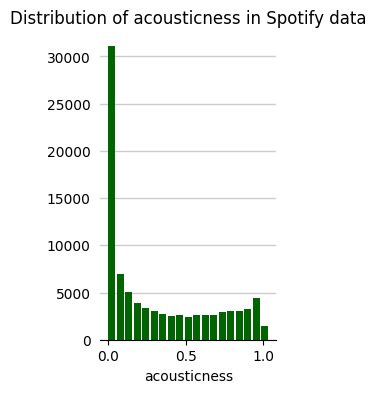

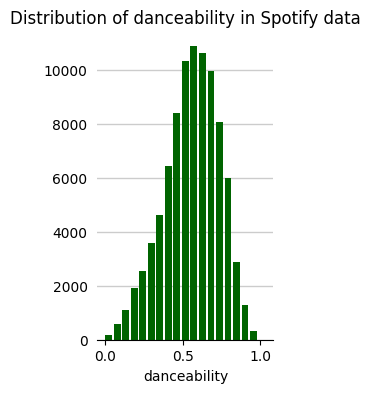

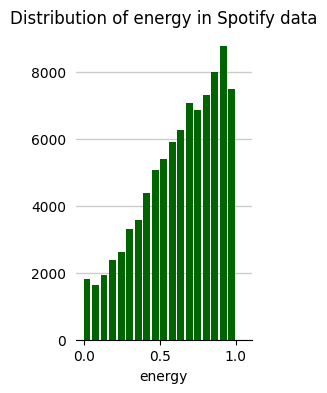

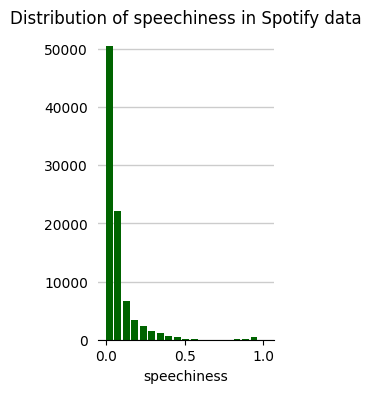

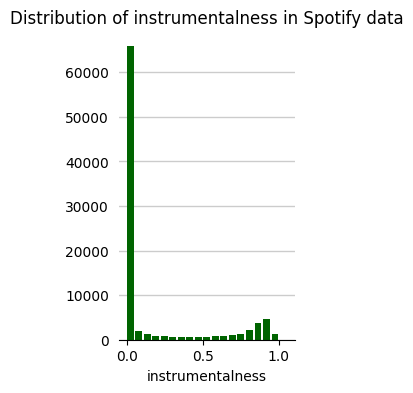

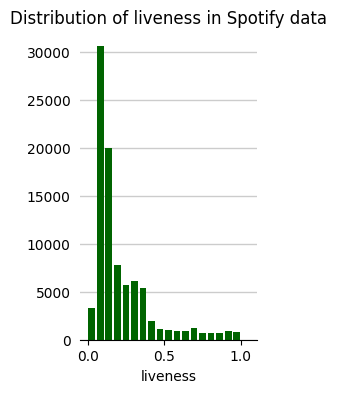

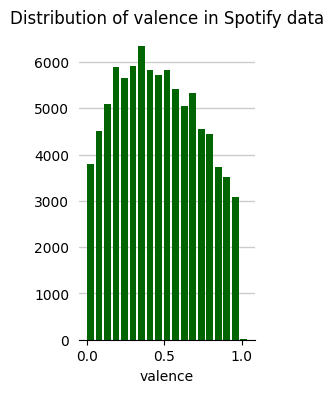

In [24]:
def DrawDistributionPlot(column_name):
  f = plt.figure(figsize=(5, 4))
  ax1 = f.add_subplot(121) # 111 refers to 1x1 grid, 1st subplot
  ax1.set_xlabel(column_name)
  #ax1.set_xlabel("POPULARITY")
  ax1.set_title(f"Distribution of {column_name} in Spotify data")
  eda = EDAVisualizer(ax1)
  eda.distribution_plot(data=new_hana_df, column=column_name,  color='darkgreen', bins=19)
#features1 = ["POPULARITY","DURATION_MS", "acousticness", "danceability", "energy","loudness","mode","speechiness","instrumentalness","liveness","valence","tempo"]
features1 = ["acousticness", "danceability", "energy","speechiness","instrumentalness","liveness","valence"]

for i in features1:

    plot = DrawDistributionPlot(i)

INFO:hana_ml.ml_base:Executing SQL: DO
BEGIN
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
param_name[1] := N'HAS_ID';
int_value[1] := 0;
double_value[1] := NULL;
string_value[1] := NULL;
params = UNNEST(:param_name, :int_value, :double_value, :string_value);
in_0 = SELECT "acousticness" FROM (SELECT "ID", "artists", "album_name", "explicit", "track_name", "popularity", "duration_ms", "genres", "danceability", "energy", "key", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "time_signature", "tempo", "loudness" FROM (SELECT * FROM "TRACKSALLFEATURESUH5") dt) AS "DT_41";
CALL _SYS_AFL.PAL_UNIVARIATE_ANALYSIS(:in_0, :params, out_0, out_1);
CREATE LOCAL TEMPORARY COLUMN TABLE "#PAL_UNIVARIATE_CONTINUOUS_TBL_34F44082_1E6A_11EE_B4C8_0242AC1C000C" AS (SELECT * FROM :out_0);
CREATE LOCAL TEMPORARY COLUMN TABLE "#PAL_UNIVARIATE_CATEGORICAL_TBL_34F44082_1E6A_

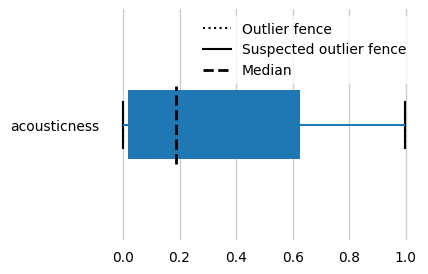

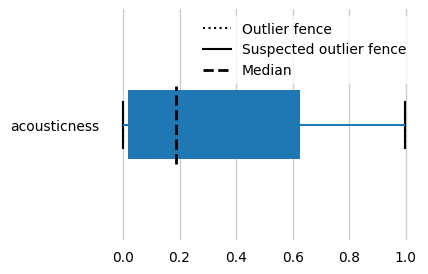

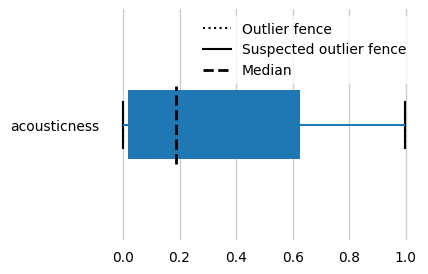

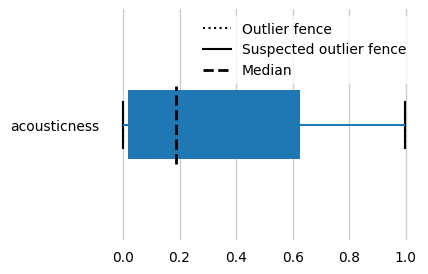

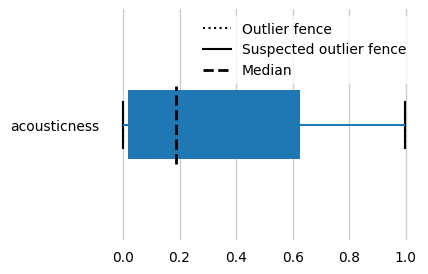

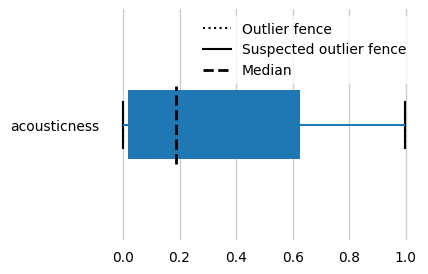

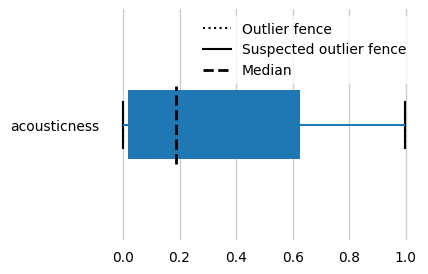

In [25]:
#Box plots are used to show distributions of numeric data values, especially when you want to compare them between multiple groups.
#They are built to provide high-level information at a glance, offering general information about a group of data’s symmetry, skew,
#variance, and outliers. It is easy to see where the main bulk of the data is, and make that comparison between different groups.

def DrawBoxPlot(column_name):
  f = plt.figure(figsize=(4, 3))
  ax1 = f.add_subplot(111)
  eda = EDAVisualizer(ax1)
  ax1, bar_data = eda.box_plot(new_hana_df, "acousticness", outliers=True, title=None, groupby=None)

features2 = ["acousticness", "danceability", "energy","speechiness","instrumentalness","liveness","valence"]

for i in features2:

    plot = DrawBoxPlot(i)

INFO:hana_ml.ml_base:Executing SQL: DO
BEGIN
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
param_name[1] := N'RESULT_TYPE';
int_value[1] := 1;
double_value[1] := NULL;
string_value[1] := NULL;
params = UNNEST(:param_name, :int_value, :double_value, :string_value);
in_0 = SELECT "acousticness", "danceability", "energy", "loudness", "speechiness", "instrumentalness", "liveness", "valence", "tempo" FROM (SELECT * FROM (SELECT "acousticness", "danceability", "energy", "loudness", "speechiness", "instrumentalness", "liveness", "valence", "tempo" FROM (SELECT * FROM "TRACKSALLFEATURESUH5") AS "DT_11") AS "DT_97" WHERE NOT ("acousticness" IS NULL OR "danceability" IS NULL OR "energy" IS NULL OR "loudness" IS NULL OR "speechiness" IS NULL OR "instrumentalness" IS NULL OR "liveness" IS NULL OR "valence" IS NULL OR "tempo" IS NULL)) AS "DT_98";
CALL _SYS_AFL.PAL_MULTIVARIATE_ANALYSIS(:in_0, :p

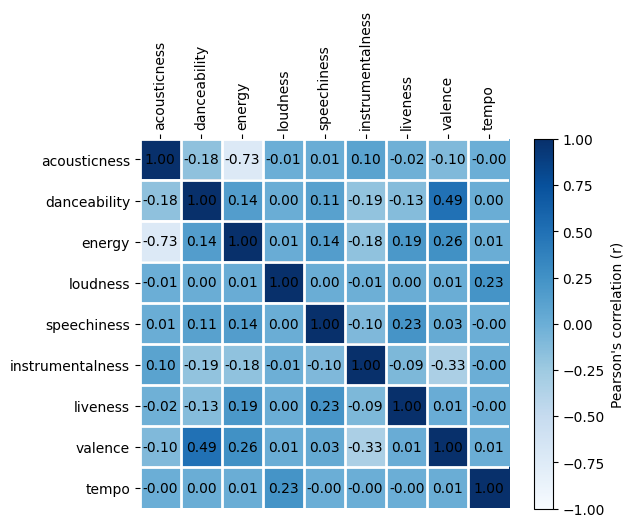

In [26]:
f = plt.figure()
ax1 = f.add_subplot(111) # 111 refers to 1x1 grid, 1st subplot
eda = EDAVisualizer(ax1)
ax, corr_data = eda.correlation_plot(data = new_hana_df, corr_cols=["acousticness", "danceability", "energy","loudness","speechiness","instrumentalness","liveness","valence","tempo"], cmap = 'Blues')

In [27]:
# The above correlation matrix shows a correlation between danceability and valence energy and valence which makes sense: a more energetic song tends to be loud and vice-cersa.
# The above correlation matrix a strong negative correlation between acousticness and danceability, energy and loudness, acousticness and energy

In [28]:
new_pandas_df = new_hana_df.collect()
most = new_pandas_df.query('popularity > 80', inplace = False).sort_values('popularity', ascending = False)

INFO:hana_ml.ml_base:Executing SQL: CREATE TABLE "TOP10GENRES_UH2" ("ID" VARCHAR(5000), "artists" VARCHAR(5000), "album_name" VARCHAR(5000), "explicit" INT, "track_name" VARCHAR(5000), "popularity" INT, "duration_ms" DOUBLE, "genres" VARCHAR(5000), "danceability" DOUBLE, "energy" DOUBLE, "key" INT, "mode" INT, "speechiness" DOUBLE, "acousticness" DOUBLE, "instrumentalness" DOUBLE, "liveness" DOUBLE, "valence" DOUBLE, "time_signature" INT, "tempo" DOUBLE, "loudness" DOUBLE);
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


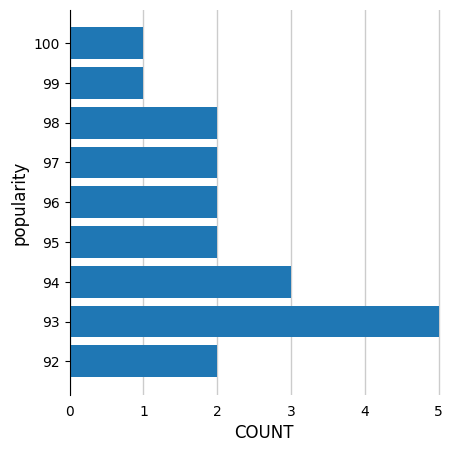

In [29]:
#top popular songs distribution
top_10_genres_df = dataframe.create_dataframe_from_pandas(
    conn, most[:20], 'TOP10GENRES_UH2')

f = plt.figure(figsize=(5, 5))
ax1 = f.add_subplot(111)
eda = EDAVisualizer(ax1)
ax1, bar_data = eda.bar_plot(data=top_10_genres_df, column="popularity",
                                aggregation={'COLUMN':'count'})


tango            1000
study             998
sleep             997
salsa             995
idm               995
bluegrass         994
grindcore         991
comedy            989
iranian           988
chicago-house     988
malay             987
club              986
heavy-metal       985
disney            983
breakbeat         983
honky-tonk        981
cantopop          969
children          969
afrobeat          966
kids              965
Name: genres, dtype: int64


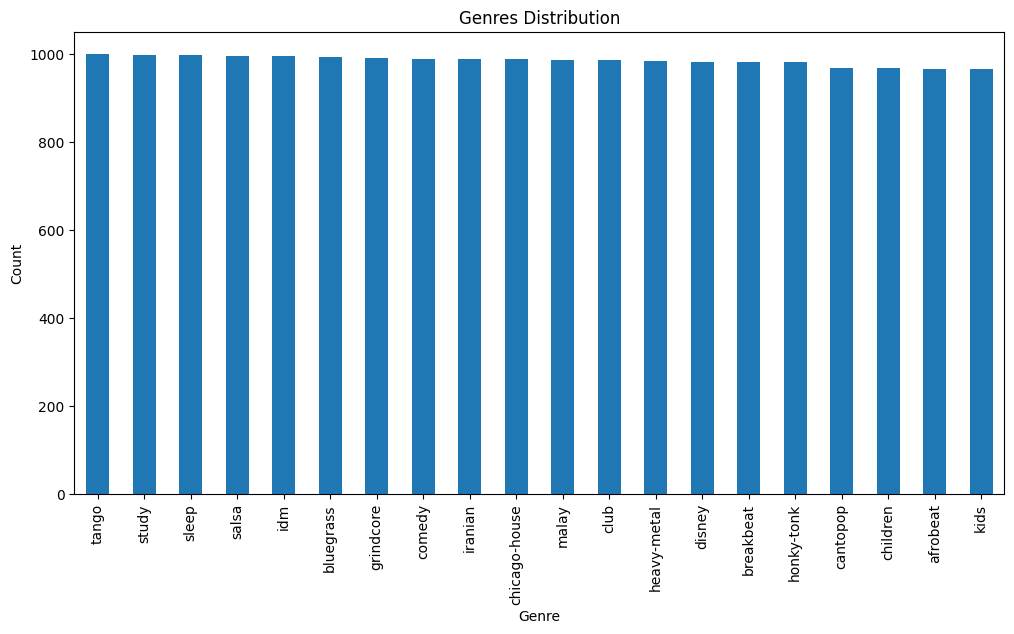

In [30]:
new_pandas_df = new_hana_df.collect()
# Calculate the genre distribution
genre_distribution = new_pandas_df['genres'].value_counts()
print(genre_distribution[:20])

# Plotting the genre distribution using matplotlib
plt.figure(figsize=(12, 6))
genre_distribution[:20].plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Genres Distribution')
plt.xticks(rotation=90)
plt.show()


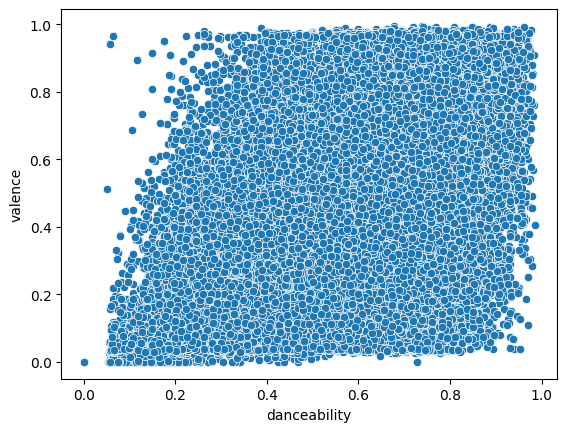

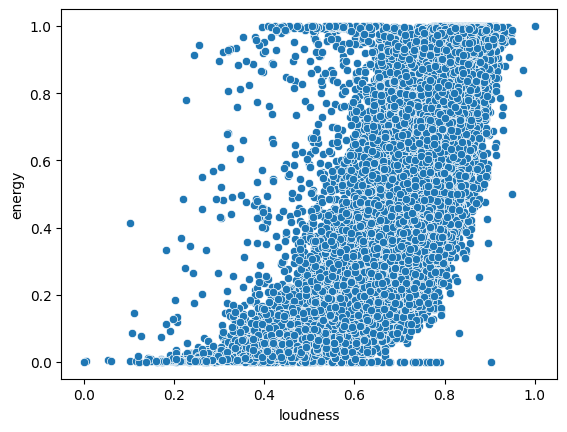

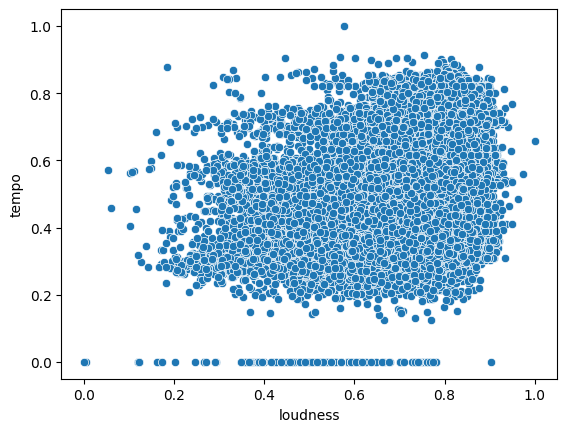

In [31]:
#plot between parameters with min correlation rating
plt.subplot(111)
sns.scatterplot(x = df['danceability'],y= df['valence'])
plt.show()

plt.subplot(111)
sns.scatterplot(x = df['loudness'],y= df['energy'])
plt.show()

plt.subplot(111)
sns.scatterplot(x = df['loudness'],y= df['tempo'])
plt.show()

INFO:hana_ml.ml_base:Executing SQL: DO
BEGIN
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
param_name[1] := N'LANGUAGE';
int_value[1] := NULL;
double_value[1] := NULL;
string_value[1] := N'EN';
param_name[2] := N'ENABLE_STOPWORDS';
int_value[2] := 0;
double_value[2] := NULL;
string_value[2] := NULL;
params = UNNEST(:param_name, :int_value, :double_value, :string_value);
in_0 = SELECT *, '1' AS "CAT" FROM (SELECT CAST(ROW_NUMBER() OVER() AS INTEGER) + 0 AS "ID", * FROM (SELECT "genres" FROM (SELECT "ID", "artists", "album_name", "track_name", "popularity", "duration_ms", "explicit", "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature", "genres" FROM (SELECT *, ROW_NUMBER() OVER (PARTITION BY "ID") AS "SEQNUM" FROM (SELECT * FROM "SPOTIFY"."AUDIOFEATURES_UH")) WHERE "SEQNUM" = 1) AS "DT_

(-0.5, 999.5, 859.5, -0.5)

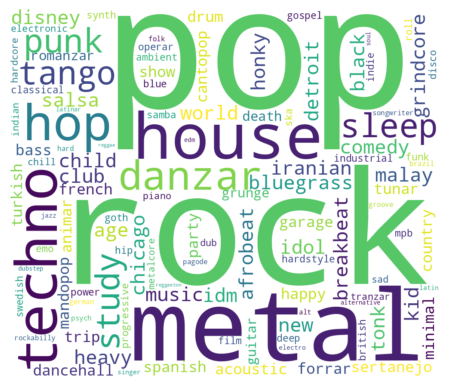

In [32]:
from hana_ml.visualizers.word_cloud import WordCloud
#stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color="white", max_words=500,
                          max_font_size=400, random_state=42, width=1000,
                          height=860, margin=2).build(data=df_remote,
                                                      #stopwords = stopwords
                                                      content_column="genres",
                                                      lang='EN')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

INFO:hana_ml.ml_base:Executing SQL: DO
BEGIN
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
param_name[1] := N'LANGUAGE';
int_value[1] := NULL;
double_value[1] := NULL;
string_value[1] := N'EN';
param_name[2] := N'ENABLE_STOPWORDS';
int_value[2] := 0;
double_value[2] := NULL;
string_value[2] := NULL;
params = UNNEST(:param_name, :int_value, :double_value, :string_value);
in_0 = SELECT *, '1' AS "CAT" FROM (SELECT CAST(ROW_NUMBER() OVER() AS INTEGER) + 0 AS "ID", * FROM (SELECT "artists" FROM (SELECT * FROM "TRACKSALLFEATURESUH5") AS "DT_11"));
CALL _SYS_AFL.PAL_TF_ANALYSIS(:in_0, :params, out_0, out_1, out_2);
CREATE LOCAL TEMPORARY COLUMN TABLE "#TM_TFIDF_RESULT_4A4BA4AC_1E6A_11EE_B4C8_0242AC1C000C" AS (SELECT * FROM :out_0);
CREATE LOCAL TEMPORARY COLUMN TABLE "#TM_TFIDF_DOC_TERM_FREQ_4A4BA4AC_1E6A_11EE_B4C8_0242AC1C000C" AS (SELECT * FROM :out_1);
CREATE LOCAL TEMPORARY COLUMN TABL

(-0.5, 999.5, 859.5, -0.5)

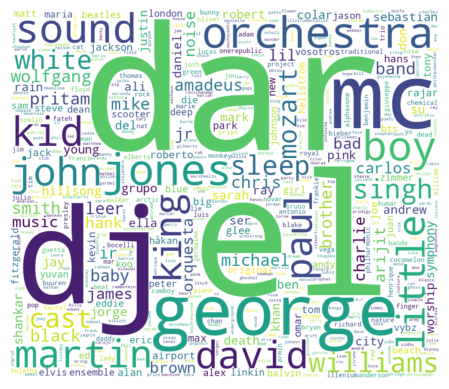

In [33]:
from hana_ml.visualizers.word_cloud import WordCloud
#stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color="white", max_words=500,
                          max_font_size=400, random_state=42, width=1000,
                          height=860, margin=2).build(data=new_hana_df,
                                                      #stopwords = stopwords
                                                      content_column="artists",
                                                      lang='EN')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [34]:
new_hana_df.collect()

,ID,artists,album_name,explicit,track_name,popularity,duration_ms,genres,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,time_signature,tempo,loudness
0,76mhYD8ORDyXAKog43BSeQ,Julia Alexa,please hold me,0,please hold me,56,192019.0,sad,0.550,0.263,4,0,0.0448,0.84200,0.000005,0.1670,0.0451,4,0.533558,0.685922
1,2UmRwtqX0LaNkbe598bHIK,Solee,Carant,0,Carant,36,460539.0,minimal-techno,0.729,0.682,1,1,0.0419,0.04550,0.837000,0.1330,0.2040,4,0.505432,0.712928
2,4B6ko7lt1sUtyFzBDF4yfK,Manolo Garcia,Arena En Los Bolsillos,0,Pajaros de Barro,63,246240.0,spanish,0.719,0.597,5,0,0.1060,0.48500,0.000000,0.0762,0.6510,4,0.595755,0.805856
3,4q7tMaar2kUMweKu6N5bZz,Elton John,Honky Chateau,0,I Think I'm Going To Kill Myself,57,215173.0,piano,0.627,0.539,0,1,0.0274,0.52600,0.000004,0.1290,0.7180,4,0.565381,0.764016
4,7gUgDucWxwsrnNGN43MZcu,Kid Abelha,Acústico (Live),0,No Seu Lugar - Ao Vivo,45,219853.0,brazil,0.619,0.754,5,1,0.0303,0.10600,0.000068,0.7030,0.6290,4,0.546386,0.795775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89736,1L4MQJhKyrw0XiF0n0C2hL,Chris Tomlin;Lady A,Chris Tomlin & Friends,0,Who You Are To Me (feat. Lady A),57,230360.0,world-music,0.518,0.778,11,0,0.0672,0.60000,0.000000,0.2130,0.7080,4,0.431504,0.855187
89737,3Nb8JQTxHJNIhavp9Fjh3i,Anıl Piyancı;Artz;Ezhel,Batı Yakası,1,Keyif Pezevengi (feat. Ezhel),42,195318.0,turkish,0.260,0.144,7,1,0.0397,0.89300,0.000000,0.2960,0.2410,3,0.520323,0.714130
89738,3Ia7UXH7fERHxzLevh9RQw,"Phillips, Craig & Dean",Let Your Glory Fall,0,Here I Am To Worship,52,232026.0,world-music,0.637,0.892,11,0,0.0809,0.00464,0.000000,0.1990,0.8450,4,0.706384,0.892459
89739,7J2gyNghNTzl4EsLhXp01Q,XXXTENTACION;Joey Bada$$,?,1,infinity (888) - feat. Joey Bada$$,74,176590.0,emo,0.427,0.587,2,1,0.0330,0.64200,0.000000,0.3150,0.5790,4,0.690388,0.851007


In [68]:
train, test, valid = partition.train_test_val_split(data = new_hana_df, training_percentage = 0.7,
                                                    testing_percentage = 0.3, validation_percentage = 0)

INFO:hana_ml.ml_base:Executing SQL: DROP TABLE "#PAL_PARTITION_DATA_TBL_B68F7410_1E8B_11EE_B4C8_0242AC1C000C"
INFO:hana_ml.ml_base:Executing SQL: CREATE LOCAL TEMPORARY COLUMN TABLE "#PAL_PARTITION_DATA_TBL_B68F7410_1E8B_11EE_B4C8_0242AC1C000C" AS (SELECT "ID", "artists", "album_name", "explicit", "track_name", "popularity", "duration_ms", "genres", "danceability", "energy", "key", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "time_signature", "tempo", "loudness" FROM (SELECT * FROM "TRACKSALLFEATURESUH5") AS "DT_11")
INFO:hana_ml.ml_base:Executing SQL: DO
BEGIN
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
param_name[1] := N'PARTITION_METHOD';
int_value[1] := 0;
double_value[1] := NULL;
string_value[1] := NULL;
param_name[2] := N'TRAINING_PERCENT';
int_value[2] := NULL;
double_value[2] := 0.7;
string_value[2] := NULL;
param_name[3] := N'TESTING_P

In [95]:
features1 = ["acousticness", "danceability", "instrumentalness", "energy","speechiness", "liveness","valence" ] #, "tempo", "loudness"]

In [96]:
kmeans = clustering.KMeans(thread_ratio=0.2, n_clusters=5, distance_level='euclidean',  #cosine
                           max_iter=10, tol=1.0E-6, category_weights=0.5, normalization='min_max')
train2 = kmeans.fit(train, 'ID', features1)
predictions = kmeans.fit_predict(test, 'ID', features1)
p = predictions.collect()
print(predictions)
#print(train2)
#res=kmeans.fit(test, 'ID', features1)

INFO:hana_ml.ml_base:Executing SQL: DO
BEGIN
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
param_name[1] := N'GROUP_NUMBER';
int_value[1] := 5;
double_value[1] := NULL;
string_value[1] := NULL;
param_name[2] := N'DISTANCE_LEVEL';
int_value[2] := 2;
double_value[2] := NULL;
string_value[2] := NULL;
param_name[3] := N'CATEGORY_WEIGHTS';
int_value[3] := NULL;
double_value[3] := 0.5;
string_value[3] := NULL;
param_name[4] := N'MAX_ITERATION';
int_value[4] := 10;
double_value[4] := NULL;
string_value[4] := NULL;
param_name[5] := N'NORMALIZATION';
int_value[5] := 2;
double_value[5] := NULL;
string_value[5] := NULL;
param_name[6] := N'THREAD_RATIO';
int_value[6] := NULL;
double_value[6] := 0.2;
string_value[6] := NULL;
param_name[7] := N'EXIT_THRESHOLD';
int_value[7] := NULL;
double_value[7] := 1e-06;
string_value[7] := NULL;
params = UNNEST(:param_name, :int_value, :double_value, :string_v

In [38]:
#print(res)

In [97]:
tsne = TSNE(n_iter=200, n_components=2, angle=0,
                 random_state=30)
train_df = predictions.collect()

In [40]:
#t-SNE (t-Distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique used for visualizing high-dimensional data in a
#lower-dimensional space. It is particularly effective in visualizing complex, nonlinear patterns in the data.

#The main idea behind t-SNE is to map each data point from its high-dimensional space to a low-dimensional space (usually 2D or 3D)
#while preserving the pairwise similarities between the points as much as possible. It achieves this by modeling the similarity between
#data points in the high-dimensional space and the low-dimensional space using a probabilistic approach.

In [98]:
train_df = predictions.collect()
tsne_pipeline = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_iter=2000, n_components=2, verbose=1))])
X = train_df.select_dtypes(np.number)
#print(X)
embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=embedding)
print(projection)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 26922 samples in 0.015s...
[t-SNE] Computed neighbors for 26922 samples in 1.312s...
[t-SNE] Computed conditional probabilities for sample 1000 / 26922
[t-SNE] Computed conditional probabilities for sample 2000 / 26922
[t-SNE] Computed conditional probabilities for sample 3000 / 26922
[t-SNE] Computed conditional probabilities for sample 4000 / 26922
[t-SNE] Computed conditional probabilities for sample 5000 / 26922
[t-SNE] Computed conditional probabilities for sample 6000 / 26922
[t-SNE] Computed conditional probabilities for sample 7000 / 26922
[t-SNE] Computed conditional probabilities for sample 8000 / 26922
[t-SNE] Computed conditional probabilities for sample 9000 / 26922
[t-SNE] Computed conditional probabilities for sample 10000 / 26922
[t-SNE] Computed conditional probabilities for sample 11000 / 26922
[t-SNE] Computed conditional probabilities for sample 12000 / 26922
[t-SNE] Computed conditional probabilities for sam

In [73]:
train_df

,ID,CLUSTER_ID,DISTANCE
0,0k30CIxipiw4Vx0NLG6qqk,5,0.343433
1,5N5v1tfDEPbvK214jUEGgO,5,0.275913
2,4xoC85cReQ3fobSv12Oi1w,3,0.377890
3,4UF7pAsGCfepAjidu2sAXl,5,0.345311
4,4CpnDXnXGK3vVcB1rj4ECV,2,0.414128
...,...,...,...
26917,329VtiB6sfTWYTL9ol6fjG,2,0.232510
26918,17QyLPoSpTDv6ThFqn9Ciw,2,0.234433
26919,3jtuZ9TxNKIvMEOTJ7bnY9,2,0.528291
26920,4lI1izPJwDoyDCrxgMCWtN,0,0.187798


In [99]:
import plotly.express as px
class_colors = {0: '#999999', 1: '#377eb8', 2: '#ff7f00', 3: '#E3CF57', 4: '#53868B' } #, 5: '#83868B', 6: '#93868B' }
projection['genres'] = train.collect()['genres']
projection['track_name'] = train.collect()['track_name']
#class_colors = {0: '#999999', 1: '#377eb8', 2: '#ff7f00', 3: '#00001', 4: '#989898'}
pred = predictions.collect()
predictions_colors = [class_colors[p] for p in pred['CLUSTER_ID'].values]
fig = px.scatter(
    projection, x='x', y='y', color=predictions_colors, hover_data=['genres', 'track_name'],title='Clusters of songs')
fig.show()

In [101]:
hg = hana.HanaGenerator(project_name="UNNATI", version='1', grant_service='ups_uh', connection_context=conn, outputdir="./test_out")
hg.config.config
hg.generate_artifacts()

'./test_out/UNNATI/hana'

In [ ]:
def plot_kmeans_results(data_set, features, predictions):

    #class_colors = {0: '#999999', 1: '#377eb8', 2: '#ff7f00'}
    pred = predictions.collect()
    predictions_colors = [class_colors[p] for p in pred['CLUSTER_ID'].values]

    red = plt.Line2D(range(1), range(1), c='w', marker='o', markerfacecolor='#999999', label='1', markersize=2, alpha=0.7)
    blue = plt.Line2D(range(1), range(1), c='w', marker='o', markerfacecolor='#377eb8', label='2', markersize=2, alpha=0.7)
    black = plt.Line2D(range(1), range(1), c='w', marker='o', markerfacecolor='#ff7f00', label='3', markersize=2, alpha=0.7)
    anotherc = plt.Line2D(range(1), range(1), c='w', marker='o', markerfacecolor='#E3CF57', label='4', markersize=2, alpha=0.7)
    anotherc1 = plt.Line2D(range(1), range(1), c='w', marker='o', markerfacecolor='#53868B', label='5', markersize=2, alpha=0.7)

    for x, y in itertools.combinations(features, 2):
        plt.figure(figsize=(4,3))
        plt.scatter(data_set[[x]].collect(), data_set[[y]].collect(), c=predictions_colors, alpha=1, s=20)
        plt.grid()
        plt.xlabel(x, fontsize=15)
        plt.ylabel(y, fontsize=15)
        plt.tick_params(labelsize=15)
        plt.legend(handles=[red, blue, black, anotherc, anotherc1])
        plt.show()

    %matplotlib notebook

In [ ]:
%matplotlib inline
plot_kmeans_results(train, features1, predictions)

In [ ]:
songs = []
#df_remote_imputed.collect() = df_remote_imputed.reset_index().collect()
for index, row in new_hana_df.collect().iterrows():
    #print(row)
    song = {
        "ID": row['ID'],
        "name": row['TRACK_NAME'],
        "features": row[features1]
    }
    songs.append(song)
#print(songs)

In [ ]:
df_remote.collect()

In [ ]:
# Get the cluster labels for the songs
#songs_clustered = songs.copy()
#songs_clustered["cluster"] = predictions["CLUSTER_ID"].collect()
#res=kmeans.fit(test, 'ID', features1)
df_clustered = kmeans.predict(train, 'ID', features1)
songs_clustered = songs.copy()
df_clustered_pd = df_clustered.collect()
songs_df = pd.DataFrame(songs_clustered, columns=['ID', 'TRACK_NAME', 'features'])
songs_df['cluster'] = df_clustered_pd['CLUSTER_ID']
#print(df_clustered_pd)
songs_df = songs_df.reset_index(drop=True)


# Define a function to recommend similar songs
def recommend_similar_songs(song_id, num_songs=5):
    song = next((s for s in songs if s["ID"] == song_id), None)
    if song is None:
        return None
    #cluster_id = model.predict(song["features"])[0][0]
    #cluster_id = kmeans.fit_predict(train, 'ID')
    clusters = kmeans.fit_predict(new_hana_df, 'ID', features1)
    cluster_ids = clusters.collect()
    #cluster_id = cluster_ids['CLUSTER_ID']
    #print(cluster_id)
    #similar_songs = songs_clustered[songs_clustered["cluster"] == cluster_id].sample(n=num_songs)
    #print(songs_df['cluster'])
    #similar_songs = df_clustered_pd.sample(n=num_songs)
    songid_cluster = cluster_ids[cluster_ids.ID==song_id]['CLUSTER_ID']
    #songid_cluster = cluster_ids.at[song_id]
    #print(cluster_ids)
    similar_songs = songs_df[songs_df.cluster==2].sample(n=num_songs)
    #print(songs_df)
    return similar_songs[["TRACK_NAME"]].to_dict("records")

# Test the recommendation function
similar_songs = recommend_similar_songs("7ndDjjFDzw6Q68TmIzgHep")
print(similar_songs)

In [ ]:
from hana_ml.model_storage import ModelStorage
SpotifyModel = ModelStorage(connection_context=conn)
kmeans.name = 'SPOTIFY_CLUSTERING'
kmeans.version = 1
SpotifyModel.save_model(model=kmeans)

In [ ]:
#hg = hana.HanaGenerator(project_name="UNNATI", version='1', grant_service='ups_uh', connection_context=conn, outputdir="./test_out")
#hg.config.config
#hg.generate_artifacts()

In [ ]:
#hg.config.config

In [ ]:
#hg.generate_artifacts()

In [ ]:
# Get the cluster labels for the songs
#songs_clustered = songs.copy()
#songs_clustered["cluster"] = predictions["CLUSTER_ID"].collect()
#res=kmeans.fit(test, 'ID', features1)
#df_clustered = kmeans.predict(train, 'ID', features1)
#songs_clustered = songs.copy()
#df_clustered_pd = df_clustered.collect()
#songs_df = pd.DataFrame(songs_clustered, columns=['ID', 'name', 'features'])
#songs_df['cluster'] = df_clustered_pd['CLUSTER_ID']
#print(df_clustered_pd)
#songs_df = songs_df.reset_index(drop=True)


# Define a function to recommend similar songs
#def recommend_similar_songs(song_id, num_songs=5):
#    song = next((s for s in songs if s["ID"] == song_id), None)
#    if song is None:
#        return None
    #cluster_id = model.predict(song["features"])[0][0]
    #cluster_id = kmeans.fit_predict(train, 'ID')
#    clusters = kmeans.fit_predict(train, 'ID', features1)
#    cluster_ids = clusters.collect()
#    cluster_id = cluster_ids['CLUSTER_ID']
    #print(cluster_id)
    #similar_songs = songs_clustered[songs_clustered["cluster"] == cluster_id].sample(n=num_songs)
#    print(df_clustered_pd['CLUSTER_ID'])
#    similar_songs = df_clustered_pd["cluster" == 0].sample(n=num_songs)
#    return similar_songs[["name", "artist"]].to_dict("records")

# Test the recommendation function
#similar_songs = recommend_similar_songs("6b8Be6ljOzmkOmFslEb23P")
#print(similar_songs)
